# SVD Based Collaborative Filtering Aloghrithm 

# for Movie Recommendation System

** Pre-define functions to be used **

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, bmat
from time import time
from os.path import isfile
import matplotlib.pyplot as plt
from numpy.linalg import norm

# The csv processing functions are wrapped in helper.py
from helper import csv_parse, write_submission

%matplotlib inline

In [2]:
def RMS(pred, true):
    rms = np.sqrt(np.sum((pred-true)**2)/len(pred))
    return rms

** Read in the training data and pre-process the data **

In [3]:
# Loading the train data
train_csv_raw = './cil-collab-filtering-2018/data_train.csv'
csv_train = './data_train_post.csv'
if isfile(csv_train):
    print('Read in processed csv_train file: Success!')
    df_train = pd.read_csv(csv_train)
else:
    df_train = csv_parse(train_csv_raw, csv_train)

# df_train.head()

Read in processed csv_train file: Success!


### Step 1: Creat a baseline solution 

We create a baseline solution by setting the missing values to the average over all observed ratings for a particular item. 

In [4]:
# Define the size of the training data
global user_N, item_N 
user_N = 10000
item_N = 1000
    
# Prepare baseline matrix 
# Calculate mean rating for every single item
mean_per_item = df_train.groupby('col_id')['Prediction'].mean().as_matrix()

# Form A with sparse matrix (more efficient)
A = coo_matrix((df_train['Prediction'], 
                (df_train['row_id']-1, df_train['col_id']-1))
              ).todense()
A = A + mean_per_item 
A[df_train['row_id']-1, df_train['col_id']-1] = df_train['Prediction']

# write_submission(A, dst='./cil-collab-filtering-2018/submission_baseline.csv')

### Step 2: SVD Decomposition

Compute the SVD Decompostion of the training matrix with the imputed values

In [5]:
# Perform SVD on matrix A
u, s, vh = np.linalg.svd(A, full_matrices=False)
s_diag = np.diag(np.sqrt(s))
u_prime = np.dot(u, s_diag)
vh_prime = np.dot(vh,s_diag)

print('Shape of userValue matrix: %d x %d' % u_prime.shape)
print('Shape of itemValue matrix: %d x %d' % vh_prime.shape)

Shape of userValue matrix: 10000 x 1000
Shape of itemValue matrix: 1000 x 1000


** Model Selection **: Select a number k of eigenvalues to be used and truncate U and V accordingly. Evaluate the model performace.

In [6]:
# rms = []
# k_range = np.arange(1, 201, 10)

# for k in k_range:
#     A_pred = np.dot(u_prime[:, 0:k], vh_prime[0:k, :])
#     df_train['my_Prediction'] = A_pred[df_train['row_id']-1, df_train['col_id']-1].T
#     rms.append(RMS(df_train['my_Prediction'], df_train['Prediction']))
    
# plt.plot(k_range, rms)
# plt.show()

###  Step 3: Make Prediction 

Make prediction about the missing values with gradient descent algorithms

** Algorithm 1: Stocastic Gradient Descent **

The misfit function here is given as: 
$$ \min_{q,p}\left.\{ \sum_{u,i\in\kappa}{(r_{ui}-q_i^Tp_u)^2} + \lambda(||q_i||^2 + ||p_u||^2)\right.\} $$

In [7]:
from numpy.random import randint, choice

def misfit_func(r, p, q, user_ids, item_ids, lamda):
    
    global user_N, item_N
    
    r_pred = np.dot(q, p)  
    err = (r.todense() - r_pred)[user_ids, item_ids]
    loss = 0.5 * np.sqrt(np.sum(np.asarray(err) **2)/len(user_ids)) #+ lamda * (norm(userValue, axis=1)+norm(itemValue, axis=0)) 
    err_matrix = coo_matrix((np.asarray(err)[0], (user_ids, item_ids))).todense()
    
    return loss, err_matrix

def SGD(r, p, q, user_ids, item_ids, gamma, max_iter, epsilon):
    
    global user_N, item_N
    
    sample = 100
    trace = []
    loss, err = misfit_func(r, p, q, user_ids, item_ids, lamda)
    print('Initial Loss: %.5f' % loss)
    print('*'*60)
    i_iter = 1
    tic = time()
    while i_iter <= max_iter and loss >= epsilon:
        loss_old = loss.copy()
        rand_ids = randint(0, len(user_ids), sample)
        for rand_id in rand_ids:
            user, item = (user_ids[rand_id], item_ids[rand_id])
            p[:, item] += gamma * (err[user, item] * q[user, :].T - lamda*p[:, item]) #np.dot(q.T, err[:, item])
            q[user, :] += gamma * (err[user, item] * p[:, item].T - lamda*q[user, :]) #np.dot(err[user, :], p.T)
        
#         users, items = (user_ids[rand_ids], item_ids[rand_ids])
#         err_sample = np.asarray(err[users, items])[0]
# #         print(err_sample.shape)
# #         print(q[users, :].T.shape)
#         p[:, items] += gamma * ((err_sample * q[users, :]).T - lamda*p[:, items])
#         q[users, :] += gamma * (err_sample * p[:, items].T - lamda*q[users, :]) 
            
        loss, err = misfit_func(r, p, q, user_ids, item_ids, lamda)
        
#         if i_iter%20==0 and loss > loss_old \
#             and sample <= 200:
#             sample += 5 
            
        trace.append([i_iter, loss])
        if i_iter % 100 == 0:
            toc = time()
            print('Iteration: %d, Misfit: %.5f, Sample: %d' % (i_iter, loss, sample))
            print('Average time per iteration: %.4f' % ((toc-tic)/i_iter))
            print('*'*60)
        
        if np.abs(loss_old-loss) <= 1e-6:
            break
        else:
            i_iter += 1 
        
    return p, q, np.asarray(trace)

In [8]:
k_select = 10      # Turncation number 
gamma = 0.1        # Learning rate
max_iter = 5000      # Maximum iteration
misfit = []          # store the misfit value
epsilon = 1e-3       # accept condition

lamda=0.1

p = vh_prime[0:k_select, :]
q = u_prime[:, 0:k_select]

# print(p.shape, q.shape)

train_data = df_train['Prediction']
user_ids = df_train['row_id'].values - 1
item_ids = df_train['col_id'].values - 1

r = coo_matrix((train_data, (user_ids, item_ids)))

p, q, trace = SGD(r, p, q, user_ids, item_ids, gamma, max_iter, epsilon)

Initial Loss: 1.90435
************************************************************
Iteration: 100, Misfit: 0.76413, Sample: 100
Average time per iteration: 0.1928
************************************************************
Iteration: 200, Misfit: 0.68221, Sample: 100
Average time per iteration: 0.1920
************************************************************
Iteration: 300, Misfit: 0.65518, Sample: 100
Average time per iteration: 0.1916
************************************************************
Iteration: 400, Misfit: 0.64241, Sample: 100
Average time per iteration: 0.1914
************************************************************
Iteration: 500, Misfit: 0.63549, Sample: 100
Average time per iteration: 0.1917
************************************************************
Iteration: 600, Misfit: 0.62491, Sample: 100
Average time per iteration: 0.1916
************************************************************
Iteration: 700, Misfit: 0.62643, Sample: 100
Average time per iteration

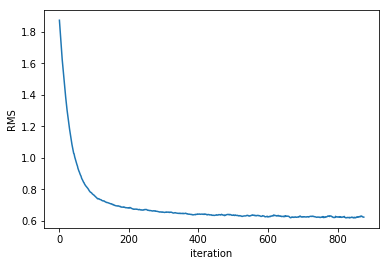

In [9]:
plt.plot(trace[:, 0], trace[:,1])
plt.xlabel('iteration')
plt.ylabel('RMS')
plt.show()

In [10]:
A_pred = np.dot(q, p)
write_submission(A_pred)

Total number of entries in the submission file: 1176952
